In [1]:
import models
import audio_utils
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import librosa
import torch.nn as nn
import os
import random
import pandas as pd
import numpy as np

In [2]:
rand_fn = '../speechRemoval/fin_dataframe.csv'
df = pd.read_csv(rand_fn)

f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
snr = [5]

noise = audio_utils.add_two_noise([f1,f2], snr)
feats_ = audio_utils.get_random_audioFeatures(noise)

f1, f2

('../audioData/NIGENS/NIGENS/footsteps/FootstepsConGritt+6016_25_1.wav',
 '../audioData/NIGENS/NIGENS/phone/TelephoneElectron+6037_36_3.wav')

In [3]:
encoder = models.logMelAE()
encoder.load_state_dict(torch.load('models/logMelAE_model_02.pt'))

<All keys matched successfully>

torch.Size([1, 40, 251])


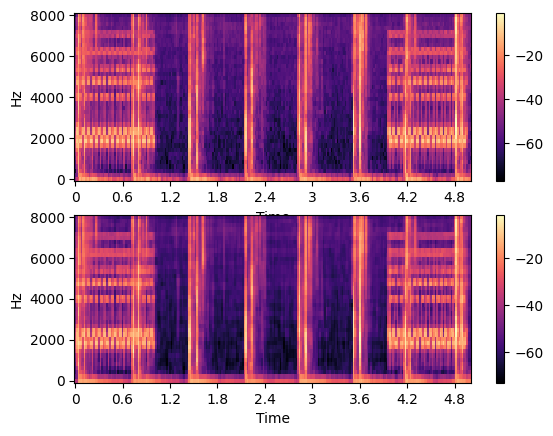

In [10]:
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000
N_MELS = 40
N_FFT = int(SAMPLE_RATE * 0.04)
HOP_LEN = int(SAMPLE_RATE * 0.02)
print(feats_.shape)
plt.subplot(2,1,1)
librosa.display.specshow(feats_.squeeze().numpy(), sr=16000, hop_length=HOP_LEN, x_axis='time', y_axis='linear')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(encoder(feats_).squeeze().detach().numpy(), sr=16000, hop_length=HOP_LEN, x_axis='time', y_axis='linear')
plt.colorbar()

In [5]:
labels_list = df['label1'].unique()
labels_list.sort()

lab_key = [i for i in range(0, len(labels_list))]
lab_dict = {labels_list[i]:lab_key[i] for i in range(0, len(labels_list))}
lab_dict['silence'] = 10

In [6]:
len([0 for i in range(0,11)]) == len(lab_dict)

True

In [94]:
[df.iloc[5, 0], df.iloc[5,1]]

['../audioData/NIGENS/NIGENS/phone/TELEPHONE-ELECTRONIC_GEN-HDF-22874.wav',
 '../audioData/NIGENS/NIGENS/piano/Piano+2017_58_5.wav']

In [7]:
class sedDataset(Dataset):

    def __init__(self, dataframe):
        self.dataset_df = dataframe

    def __len__(self):
        return len(self.dataset_df)
    
    def __getitem__(self, index):

        fil_list = [self.dataset_df.iloc[index, 0], self.dataset_df.iloc[index, 1]]
        lab1 = lab_dict[self.dataset_df.iloc[index, 2]]
        lab2 = lab_dict[self.dataset_df.iloc[index, 3]]
        
        noise = audio_utils.add_two_noise(fil_list, [5])
        feats = audio_utils.get_random_audioFeatures(noise)
        
        if torch.isnan(noise).any():
            noise = torch.zeros(noise.shape)
            lab1 = lab_dict['silence']
            lab2 = lab_dict['silence']
            feats = torch.zeros(feats.shape)
            
               
        labels = [0 for i in range(0,11)]
        labels[lab1] = 1
        labels[lab2] = 1
        labels = torch.Tensor(labels)
        
        return feats, labels

In [8]:
split = (int)(len(df)*0.8)

train_dataset = sedDataset(df[0:split])
test_dataset = sedDataset(df[split:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [57]:
feats_.shape

torch.Size([1, 40, 251])

In [61]:
rarr = torch.rand([1,40,251])

vrom = nn.Sequential(nn.Conv2d(1,32,3),
                     nn.ReLU(),
                     nn.Conv2d(32,64,3),
                     nn.ReLU(),
                     nn.Conv2d(64,16,3),
                     nn.ReLU(),
                     nn.Conv2d(16,1,3),
                     nn.ReLU(),
                     nn.Flatten(),
                     nn.Linear(7776,220),
                     nn.ReLU(),
                     nn.Linear(220,11),
                     nn.ReLU())

vrom(rarr)

tensor([[0.0264, 0.0000, 0.0339, 0.0000, 0.0548, 0.0221, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0221]], grad_fn=<ReluBackward0>)

In [62]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class AEDClassifier(nn.Module):

    def __init__(self):
        super(AEDClassifier, self).__init__()

        self.classifier = nn.Sequential(nn.Conv2d(1,32,3),
                                        nn.ReLU(),
                                        nn.Conv2d(32,64,3),
                                        nn.ReLU(),
                                        nn.Conv2d(64,16,3),
                                        nn.ReLU(),
                                        nn.Conv2d(16,1,3),
                                        nn.ReLU(),
                                        nn.Flatten(),
                                        nn.Linear(7776,220),
                                        nn.ReLU(),
                                        nn.Linear(220,11),
                                        nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.classifier(x)
        y = self.sigmoid(x)

        return y

In [64]:
sas = torch.rand([1,40,251])

AEDClassifier()(sas)

tensor([[0.5126, 0.5000, 0.5000, 0.5000, 0.5060, 0.5112, 0.5087, 0.5093, 0.5000,
         0.5037, 0.5005]], grad_fn=<SigmoidBackward0>)

In [65]:
sed_classifier = AEDClassifier()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(sed_classifier.parameters(), lr=0.01)

In [78]:
import statistics

sed_classifier = sed_classifier.to(device)
encoder = encoder.to(device)

epochs = 10

for epoch in range(0, epochs):
    loc_list = []

    for data in train_loader:
        sed_classifier.train()
        inputs, labes = data

        inputs = inputs.to(device)
        if not torch.isnan(inputs).any():
            labes = labes.to(device)

            output = sed_classifier(inputs)
            #print(output.shape, labes.shape)
            loss = loss_fn(output, labes)

            optimizer.zero_grad()
            if not torch.isnan(loss).any():
                loss.backward()
                loc_list.append(loss.item())    

    print(f"Epoch [{epoch+1}/{epochs}] Loss: [{statistics.mean(loc_list)}]")

Epoch [1/10] Loss: [4.796215890884399]
Epoch [2/10] Loss: [4.796215890884399]
Epoch [3/10] Loss: [4.796215900421142]
Epoch [4/10] Loss: [4.796215877532959]
Epoch [5/10] Loss: [4.796215898513794]
Epoch [6/10] Loss: [4.796215900421142]
Epoch [7/10] Loss: [4.796215892791748]
Epoch [8/10] Loss: [4.796215883255005]
Epoch [9/10] Loss: [4.796215892791748]
Epoch [10/10] Loss: [4.796215906143188]


In [86]:
import torchmetrics
acc_list = []
sed_classifier = sed_classifier.to('cpu')
encoder = encoder.to('cpu')

multi_lab_acc = torchmetrics.classification.MultilabelAccuracy(num_labels=len(lab_dict), average=None)
conf_mat = torchmetrics.classification.MultilabelConfusionMatrix(num_labels=len(lab_dict))
for data in test_loader:

    sed_classifier.eval()
    encoder.eval()
    inpu, labs = data

    with torch.no_grad():
        repr = encoder.encoder(inpu)
        out_ = sed_classifier(repr)
        torch.round(out_)
    out_ = out_.to('cpu', torch.int)
    labs = labs.to('cpu', torch.int)
    multi_lab_acc.update(out_, labs)
    conf_mat.update(out_, labs)

fig1, ax1 = multi_lab_acc.plot()
fig2, ax2 = conf_mat.plot()

/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 16, 10, 63] to have 1 channels, but got 16 channels instead

In [85]:
f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
print(f1,f2)
noise = audio_utils.add_two_noise([f1,f2], [5])
featss = audio_utils.get_random_audioFeatures(noise)

'''encoder = encoder.cpu()
encoder.eval()
with torch.no_grad():
    repres = encoder.encoder(featss)
'''
sed_classifier = sed_classifier.cpu()
sed_classifier.eval()
with torch.no_grad():
    out = sed_classifier(featss)

print(torch.round(out), lab_dict)

../audioData/NIGENS/NIGENS/knock/KnockerDoor+9006_38_8.wav ../audioData/NIGENS/NIGENS/phone/TelephoneCellular+6068_16_2.wav
tensor([[1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.]]) {'alarm': 0, 'baby': 1, 'crash': 2, 'dog': 3, 'engine': 4, 'fire': 5, 'footsteps': 6, 'knock': 7, 'phone': 8, 'piano': 9, 'silence': 10}
